## Spooky Author Identification

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

#### Data fields
* id - a unique identifier for each sentence
* text - some text written by one of the authors
* author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

***

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

### Read 'spooky.csv' dataset

In [2]:
df=pd.read_csv('spooky.csv')

In [3]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Drop 'id' column

In [4]:
df.drop(columns='id',inplace=True)

In [5]:
df

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


### Check for missing values

In [6]:
df.isna().sum()

text      0
author    0
dtype: int64

### Check for duplicates

In [7]:
df.duplicated().sum()

0

### Print some of the text along with its author

In [8]:
df.columns

Index(['text', 'author'], dtype='object')

In [9]:
for i in range(5):
    print(df['text'][i],' - ',df['author'][i])
    print()

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.  -  EAP

It never once occurred to me that the fumbling might be a mere mistake.  -  HPL

In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.  -  EAP

How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.  -  MWS

Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.  -  HPL



### Create a function to preproces the text

In [10]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [11]:
def prepo(t):
    txt=re.sub(r"[^a-zA-Z0-9]",' ',t).split()
    txt=[i.lower() for i in txt if i not in stopwords.words('english')]
    
    lemma = WordNetLemmatizer()
    txt=[lemma.lemmatize(word,'v') for word in txt]
    txt=' '.join(txt)
    return txt

### Print some of the text after preprocess

In [12]:
df['text']=df['text'].apply(prepo)

In [14]:
for i in range(5):
    print(df['text'][i],' - ',df['author'][i])
    print()

this process however afford mean ascertain dimension dungeon i might make circuit return point whence i set without aware fact perfectly uniform seem wall  -  EAP

it never occur fumble might mere mistake  -  HPL

in leave hand gold snuff box caper hill cut manner fantastic step take snuff incessantly air greatest possible self satisfaction  -  EAP

how lovely spring as look windsor terrace sixteen fertile counties spread beneath speckle happy cottages wealthier towns look former years heart cheer fair  -  MWS

find nothing else even gold superintendent abandon attempt perplex look occasionally steal countenance sit think desk  -  HPL



### Check for imbalance in the dataset

<Axes: ylabel='count'>

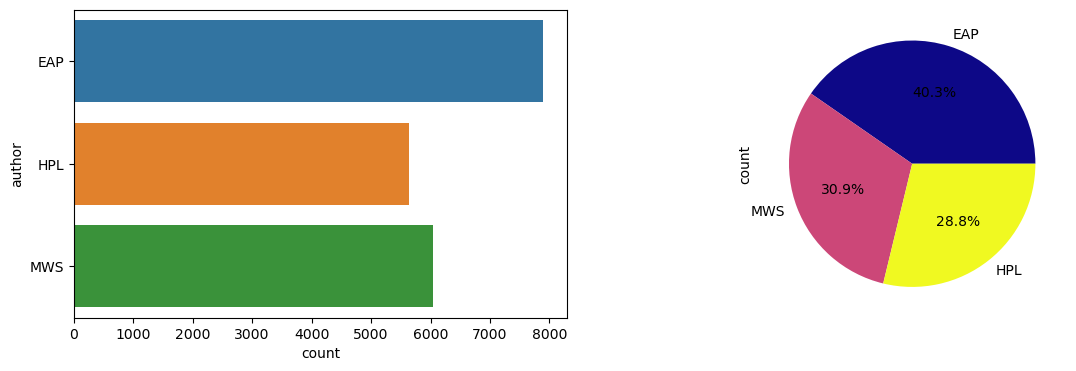

In [15]:
plt.figure(figsize= (14,4))
plt.subplot(1,2,1)
sns.countplot(y = df['author'])
plt.subplot(1,2,2)
df['author'].value_counts().plot.pie(autopct = '%1.1f%%', cmap = 'plasma')

### Split the dataset into Input & Target Variables

In [16]:
X=df['text']
y=df['author']

### Label Encode our target variables

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
label=LabelEncoder()

In [19]:
y=label.fit_transform(y)

In [40]:
y

array([0, 1, 0, ..., 0, 0, 1])

In [39]:
y.shape

(19579,)

### Create Keras tokenizer object with 5000 max words
* Convert text to sequence
* Add padding

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
token=Tokenizer(num_words=5000)

In [26]:
token.fit_on_texts(X)

In [27]:
vocab=len(token.word_index)+1

In [29]:
def pad(x):
    en=token.texts_to_sequences(x)
    pad=pad_sequences(en,maxlen=128)
    return pad

In [30]:
X=pad(X)

### Split the dataset into Training & Testing set

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

### Create keras Sequential model with GRU layers

In [33]:
from tensorflow.keras import Sequential,layers

In [36]:
model=Sequential([
    layers.Embedding(vocab,128),
    layers.GRU(128,return_sequences=True),
    layers.Dropout(0.2),
    layers.GRU(128),
    layers.Dropout(0.2),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3,activation='softmax')
    
])
    

### Compile the model

In [41]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Train the model

In [42]:
model.fit(X_train,y_train,epochs=10,validation_split=0.05)

Epoch 1/10


465/465 [==============================] - 128s 257ms/step - loss: 0.6854 - accuracy: 0.6952 - val_loss: 0.4543 - val_accuracy: 0.8214
Epoch 2/10
465/465 [==============================] - 119s 255ms/step - loss: 0.3830 - accuracy: 0.8482 - val_loss: 0.4720 - val_accuracy: 0.8087
Epoch 3/10
465/465 [==============================] - 120s 258ms/step - loss: 0.2881 - accuracy: 0.8887 - val_loss: 0.4763 - val_accuracy: 0.8138
Epoch 4/10
465/465 [==============================] - 119s 256ms/step - loss: 0.2101 - accuracy: 0.9212 - val_loss: 0.5417 - val_accuracy: 0.7946
Epoch 5/10
465/465 [==============================] - 118s 254ms/step - loss: 0.1558 - accuracy: 0.9388 - val_loss: 0.6758 - val_accuracy: 0.8048
Epoch 6/10
465/465 [==============================] - 117s 251ms/step - loss: 0.1163 - accuracy: 0.9554 - val_loss: 0.6718 - val_accuracy: 0.8138
Epoch 7/10
465/465 [==============================] - 116s 250ms/step - loss: 0.0850 - accuracy: 0.9700 - val_loss: 0.8769

### Make predictions with X_test

In [43]:
y_pred=model.predict(X_test)

123/123 [==============================] - 11s 77ms/step


### Fetch the index of the higher probable prediction

In [44]:
y_pred=[np.argmax(i) for i in y_pred]

### Evaluate the model

#### Accuracy score

In [45]:
metrics.accuracy_score(y_test,y_pred)

0.7683861082737488

#### Confusion matrix

<Axes: >

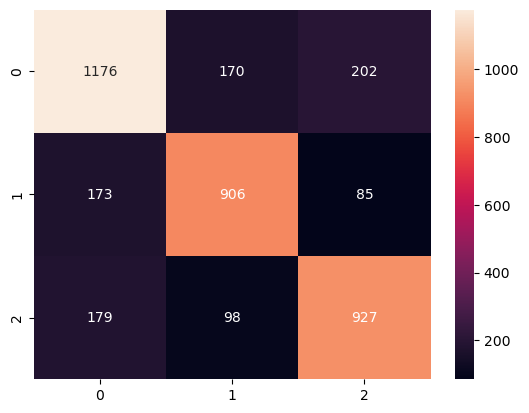

In [47]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='d')

#### Classification Report

In [48]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1548
           1       0.77      0.78      0.78      1164
           2       0.76      0.77      0.77      1204

    accuracy                           0.77      3916
   macro avg       0.77      0.77      0.77      3916
weighted avg       0.77      0.77      0.77      3916

